# Mendownload Dataset dan Import library

## Menginstall Package

In [1]:
!pip install -q kaggle

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varenzowie","key":"c3008a5e87b883ba27775cd6d5071f74"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d mateuszk013/warsaw-daily-weather

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 55.6MB/s]


## Pembuatan direktori dan unzip file

In [6]:
!warsaw-daily-weather
!unzip warsaw-daily-weather.zip -d warsaw-daily-weather
!ls warsaw-daily-weather

/bin/bash: line 1: warsaw-daily-weather: command not found
Archive:  warsaw-daily-weather.zip
  inflating: warsaw-daily-weather/warsaw.csv  
warsaw.csv


In [7]:
df = pd.read_csv('warsaw-daily-weather/warsaw.csv')

# Proses Data Cleaning

In [8]:
#Menampilkan isi dari dataset
df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-01,0.0,10.0,-8.3,NaN,NaN
1,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-02,NaN,10.0,-14.9,NaN,NaN
2,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-03,0.0,10.0,-13.6,-9.7,NaN
3,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-04,0.0,10.0,-10.5,-6.5,-13.3
4,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-05,0.0,10.0,-12.0,-8.9,-14.1
...,...,...,...,...,...,...,...,...,...,...,...
10949,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-27,8.4,NaN,4.7,9.4,2.7
10950,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-28,0.0,NaN,3.3,NaN,NaN
10951,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-29,0.5,NaN,6.8,NaN,3.7
10952,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-30,0.0,NaN,6.1,9.2,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    10954 non-null  object 
 1   NAME       10954 non-null  object 
 2   LATITUDE   10954 non-null  float64
 3   LONGITUDE  10954 non-null  float64
 4   ELEVATION  10954 non-null  float64
 5   DATE       10954 non-null  object 
 6   PRCP       9158 non-null   float64
 7   SNWD       1423 non-null   float64
 8   TAVG       10954 non-null  float64
 9   TMAX       7463 non-null   float64
 10  TMIN       5870 non-null   float64
dtypes: float64(8), object(3)
memory usage: 941.5+ KB


Disini saya hanya menggunakan TAVG yang adalah Average Temperature menjadi model pembelajaran machine learning saya.

In [10]:
df_baru = df[["DATE", "TAVG"]]
df_baru = df_baru.copy()
df_baru['DATE'] = pd.to_datetime(df_baru['DATE'])

In [11]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    10954 non-null  datetime64[ns]
 1   TAVG    10954 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 171.3 KB


In [12]:
df_baru.isnull().sum()

DATE    0
TAVG    0
dtype: int64

# Data Processing

In [13]:
df_baru = df_baru.set_index('DATE')
scaler = MinMaxScaler(feature_range = (0, 1))
data_baru1 = scaler.fit_transform(df_baru)

In [26]:
tavg_column = data_baru1[:, df_baru.columns.get_loc("TAVG")]
threshold_mae = (tavg_column.max() - tavg_column.min()) * 10 / 100
print(f"Nilai Mae adalah {threshold_mae}%")

Nilai Mae adalah 0.1%


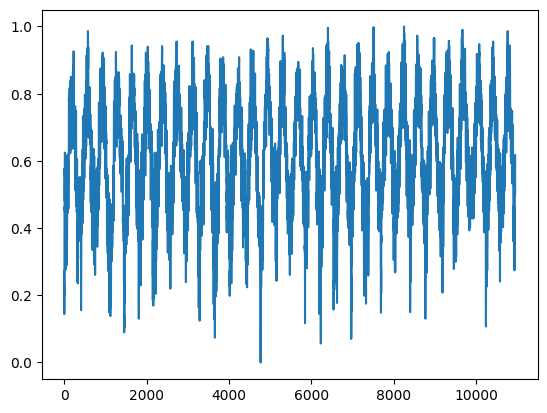

In [15]:
plt.plot(data_baru1)

## Pemisahan data train dan data test

In [16]:
train_size = int(len(data_baru1)*0.8)
test_size = len(data_baru1) - train_size
X_data, y_data = data_baru1[0: train_size, :], data_baru1[train_size: len(data_baru1), :1]
train_size, test_size

(8763, 2191)

In [17]:
def dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)


In [18]:
X_train, y_train = dataset(X_data, 100)
X_test, y_test = dataset(y_data, 100)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Pembuatan Model

In [19]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 1)),
    Dropout(0.1),
    Bidirectional(LSTM(64)),
    Dropout(0.1),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])


# Testing Data

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128, verbose=1, callbacks=early_stopping)

Epoch 1/20
68/68 [==============================] - 76s 979ms/step - loss: 0.1561 - mae: 0.5175 - val_loss: 0.0131 - val_mae: 0.1377
Epoch 2/20
68/68 [==============================] - 48s 701ms/step - loss: 0.0151 - mae: 0.1452 - val_loss: 0.0131 - val_mae: 0.1374
Epoch 3/20
68/68 [==============================] - 50s 734ms/step - loss: 0.0136 - mae: 0.1374 - val_loss: 0.0086 - val_mae: 0.1074
Epoch 4/20
68/68 [==============================] - 46s 680ms/step - loss: 0.0052 - mae: 0.0797 - val_loss: 0.0034 - val_mae: 0.0662
Epoch 5/20
68/68 [==============================] - 48s 706ms/step - loss: 0.0034 - mae: 0.0653 - val_loss: 0.0025 - val_mae: 0.0564
Epoch 6/20
68/68 [==============================] - 48s 714ms/step - loss: 0.0030 - mae: 0.0614 - val_loss: 0.0029 - val_mae: 0.0613
Epoch 7/20
68/68 [==============================] - 49s 727ms/step - loss: 0.0029 - mae: 0.0605 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 8/20
68/68 [==============================] - 49s 717ms/step - 

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

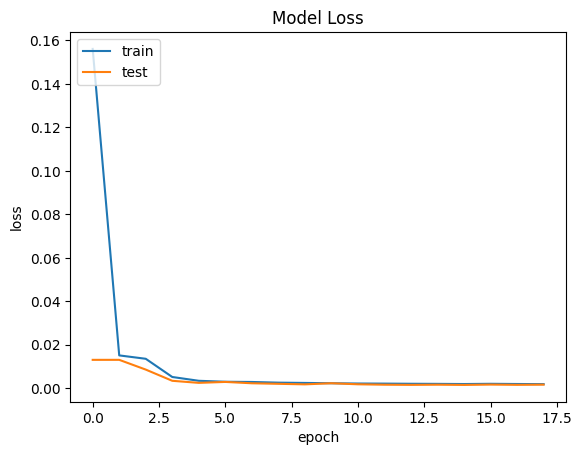

In [23]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

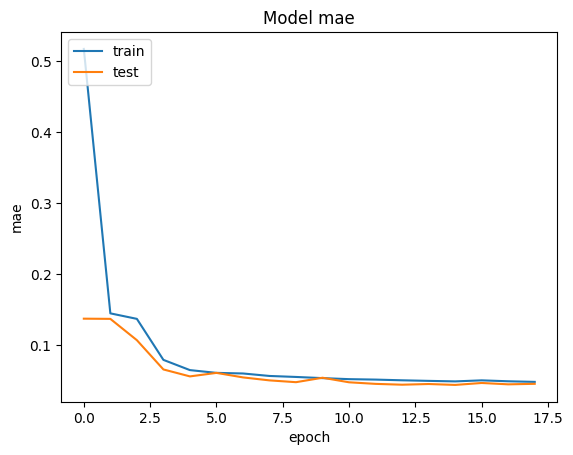

In [24]:
plt.plot(mae)
plt.plot(val_mae)
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()